In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler

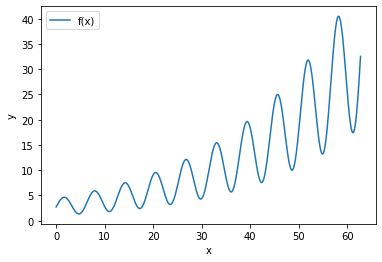

In [48]:
tEnd = 20*math.pi
nSamples = 1000
dt = tEnd/nSamples
x = np.arange(0, tEnd, dt)
y = np.exp(0.5 + x*0.035) * np.sin(x) + np.exp(1 + x*0.04)

plt.plot(x, y, label='f(x)')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()

In [0]:
testIndex = int(nSamples * 0.75)
numFeatures = 1
yReshaped = y.reshape((len(y), numFeatures))

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
yScaled = scaler.fit_transform(yReshaped)

numInputs = 2
train = TimeseriesGenerator(yScaled, yScaled, length=numInputs, batch_size=8, start_index=0, end_index=testIndex)
test = TimeseriesGenerator(yScaled, yScaled, length=numInputs, batch_size=8, start_index=testIndex)

In [50]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(numInputs, numFeatures)))
model.add(LSTM(100, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 2, 100)            40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit_generator(train, steps_per_epoch=1, epochs=300, verbose=1, validation_data=test)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.0281 - val_loss: 0.3592
Epoch 2/300
1/1 [==============================] - 0s 184ms/step - loss: 0.0116 - val_loss: 0.3537
Epoch 3/300
1/1 [==============================] - 0s 180ms/step - loss: 0.0422 - val_loss: 0.3482
Epoch 4/300
1/1 [==============================] - 0s 189ms/step - loss: 0.0153 - val_loss: 0.3428
Epoch 5/300
1/1 [==============================] - 0s 184ms/step - loss: 0.0021 - val_loss: 0.3380
Epoch 6/300
1/1 [==============================] - 0s 184ms/step - loss: 0.0059 - val_loss: 0.3333
Epoch 7/300
1/1 [==============================] - 0s 183ms/step - loss: 0.0038 - val_loss: 0.3287
Epoch 8/300
1/1 [==============================] - 0s 198ms/step - loss: 0.0178 - val_loss: 0.3238
Epoch 9/300
1/1 [==============================] - 0s 191ms/step - loss: 0.0162 - val_loss: 0.3187
Epoch 10/300
1/1 [==============================] - 0s 178ms/step - loss: 5.0742e-04 - val_loss: 0.3138
Epoch 11

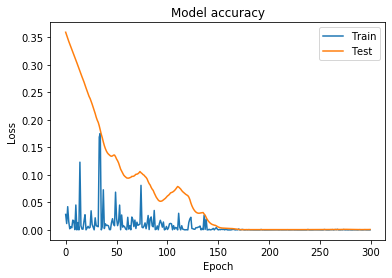

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [53]:
yScaled.shape

(1000, 1)

In [54]:
trainLoss = model.evaluate_generator(train)
testLoss = model.evaluate_generator(test)
print('Train loss: ', trainLoss)
print('Test loss: ', testLoss)

Train loss:  0.00017223508931872187
Test loss:  0.0007889948199355727


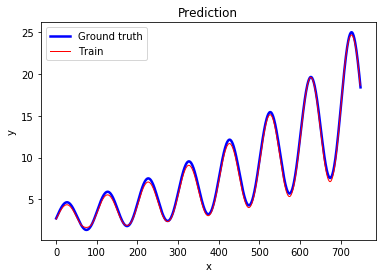

In [55]:
yTrainPredicted = scaler.inverse_transform(model.predict_generator(train))

plt.plot(y[0:testIndex], color='blue', linewidth=2.5)
plt.plot(yTrainPredicted, color='red', linewidth=1.0)
plt.title('Prediction')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Ground truth', 'Train'], loc='best')
plt.show()

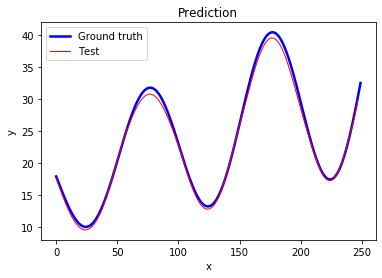

In [60]:
yPredicted = scaler.inverse_transform(model.predict_generator(test))

plt.plot(y[testIndex:], color='blue', linewidth=2.5)
plt.plot(yPredicted, color='red', linewidth=1.0)
plt.title('Prediction')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Ground truth', 'Test'], loc='best')
plt.show()

In [57]:
last2 = yScaled[testIndex:testIndex+numInputs].reshape(numInputs)
last2

array([0.42304302, 0.41040611])

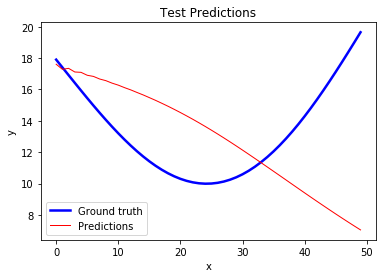

In [61]:
nextX = last2.reshape((1, numInputs, numFeatures))
yValues = []
yPredictions = []
for i in range(50):
    nextY = model.predict(nextX)
    nextX = np.roll(nextX, -1)
    nextX[-1][-1][-1] = nextY[-1][0]
    yPredictions.append(scaler.inverse_transform(nextY)[-1][0])
    yValues.append(y[testIndex+i])

plt.plot(yValues, color='blue', linewidth=2.5)
plt.plot(yPredictions, color='red', linewidth=1.0)
plt.title('Test Predictions')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Ground truth', 'Predictions'], loc='best')
plt.show()